# CS 512 F24: Assignment 3


Due by 10/19/2024

**Name:** Tamilarasee Sethuraj

**Student ID:** A20553416



# 1. Robust Estimation

1. Generate points that belong to a line segment with given parameters (angle and distance from the origin). Test your line generation by creating points for lines with angles between 0 and 90 degrees, and plot the results. 
The "angle" refers to the line angle. You need to compute the normal vector of the line using this angle, and then generating the point using the implicit line equation: n.p-d=0

$$n.p - d = 0 $$
$$n.p = d  $$
$$ (n_x, n_y) · (x, y) = d $$
$$ n_x * x + n_y * y = d $$
Given x, 
$$ y = \frac{d - n_x * x}{n_y} $$
where, $$n_x = nCos\theta$$
$$n_y = nSin\theta$$
Considering n to be unit vector, 
$$n_x = Cos\theta$$
$$n_y = Sin\theta$$
For various values of $\theta$, d and x, we will have to find the value of y to generate multiple lines

In [356]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [357]:
def generate_points (theta, d):
    theta_rad = math.radians(theta)
    n_x = math.cos(theta_rad)
    n_y = math.sin(theta_rad)    
    x_values =  np.linspace(-20,20,200)   # used to evenly create 100 x between -20 and 20 
    y_values = (d - (n_x *x_values))/n_y         
    return x_values,y_values


theta_values = [30,45,60]
d_values = [0,20,40]
points = {}
for theta in theta_values:
    for d in d_values:
        x,y=generate_points(theta,d)
        points[(theta,d)] = (x,y)


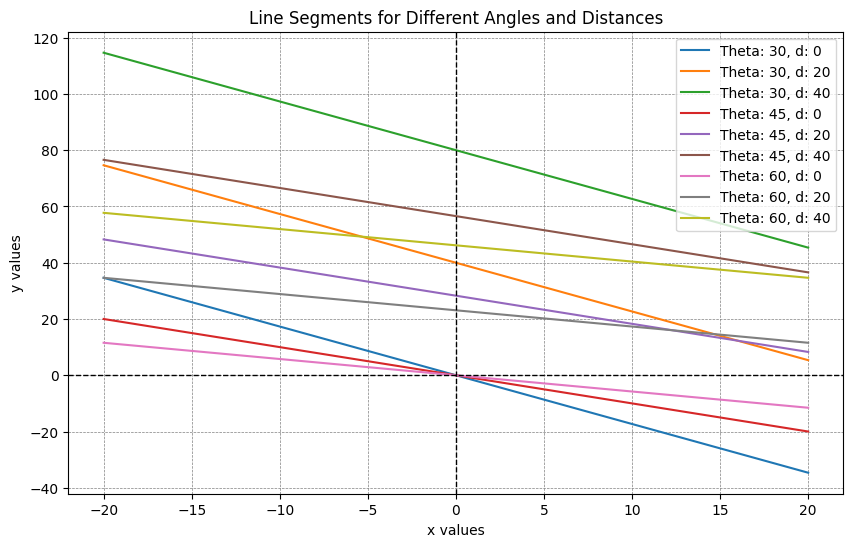

In [358]:
plt.figure(figsize=(10, 6))

for (theta, d), (x_values, y_values) in points.items():
    plt.plot(x_values, y_values,label=f'Theta: {theta}, d: {d}')

plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Line Segments for Different Angles and Distances')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

2. Add Gaussian noise with specified mean and standard deviation to the points of a specific line segment, and plot the noisy points. Ensure that the noise is visible

In [359]:
def generate_noisy_points(theta, d, std_dev):
    x,y = generate_points(theta,d)
    mean = 0
    x_noise = np.random.normal(mean, std_dev,x.shape)
    y_noise = np.random.normal(mean, std_dev,y.shape)
    noisy_x = x + x_noise
    noisy_y = y + y_noise
    return noisy_x, noisy_y


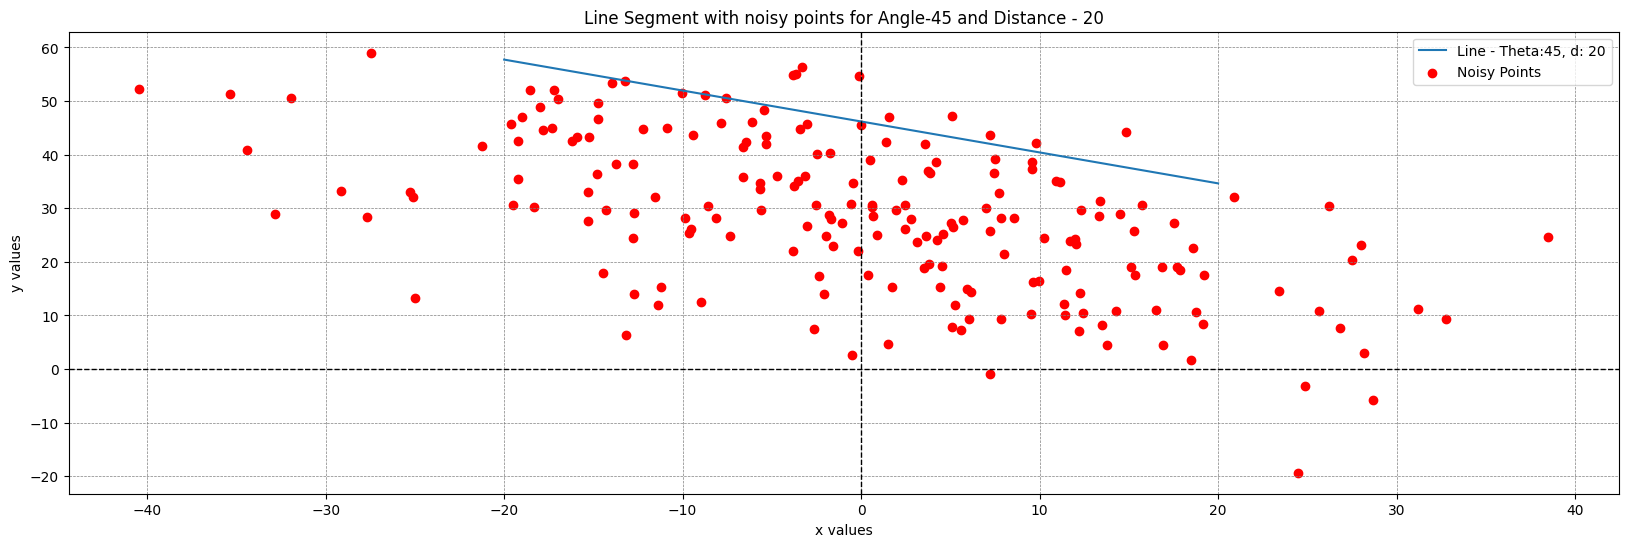

In [360]:
noisy_x, noisy_y = generate_noisy_points(45, 20, 10)

plt.figure(figsize=(20, 6))

plt.plot(x, y,label=f'Line - Theta:45, d: 20')
plt.scatter(noisy_x,noisy_y,color='red', label='Noisy Points')
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Line Segment with noisy points for Angle-45 and Distance - 20')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

3. Given the noisy points from the previous step, estimate the parameters of the original line and compute the error compared to the known parameters. Use the cv2.fitLine function to estimate the parameters, utilizing the CV_DIST_L2 distance.Use parameter error (L1) separately for angle and distance.

The output of cv2.fitLine gives the direction vector of the line(parallel to the line) which is at 90 degrees to normal vector. n_x = direction_y and n_y = - direction_x


In [361]:
# Fit a line for a given set of points and estimate the line parameters (theta and d)

def estimate_parameters(noisy_x,noisy_y):

    noisy_points = np.column_stack((noisy_x,noisy_y)).astype(np.float32)
    direction_x,direction_y, x,y = cv2.fitLine(noisy_points,distType=cv2.DIST_L2,param=0,reps=0.01, aeps=0.01)  
    # distType=cv2.DIST_L2 - Euclidean (L2) distance -least squares method- sqrt((x1-x2)^2 + (y1-y2)^2)
    # param- setting threshold for other distypes,  reps - maximum radial (dist) accuracy threshold allowed, aeps- maximum angle accuracy threshold allowed
    # dir_x,dir_y,x,y - all are returned as single-element arrays ---we can use np.atan, np multiplications below as well

    theta_estimated = math.atan2(direction_y[0],direction_x[0])  # atan2 return angles in all 4 quadrants , The angle between the positive x-axis and the ray from the origin (0, 0) to the point (direction_x, direction_y)
    theta_estimated = math.degrees(theta_estimated) %360
    d_estimated = abs((direction_y[0] * x[0]) + (- direction_x[0] * y[0]))

    return theta_estimated, d_estimated



def compute_error(theta_original,d_original,theta_estimated,d_estimated):
    # Parameter error (L1) - absolute difference between the estimated and true values
    #theta_error = abs(theta_original - theta_estimated)
    #theta_error = min((theta_original - theta_estimated) % 360, (theta_estimated - theta_original) % 360)
    theta_error = abs(min((360 - theta_estimated), theta_estimated) - theta_original)  # this helps to find how far is the estimated theta from 0/360 so that it is a fair comparison with theta original
    d_error = abs(d_original - d_estimated)
    return theta_error,d_error


theta = 45
d= 20
std_dev =5
noisy_x,noisy_y = generate_noisy_points(theta, d, std_dev)
theta_estimated,d_estimated = estimate_parameters(noisy_x,noisy_y)
theta_error,d_error = compute_error(theta,d,theta_estimated,d_estimated)
print(f"For std_dev = {std_dev}, Angle Error is {theta_error:.2f} degrees, Distance error is {d_error:.2f}")


For std_dev = 5, Angle Error is 0.22 degrees, Distance error is 0.47


4. Plot a graph showing the error as a function of the noise level. The plot must be properly labeled. At a minimum, it should include a title, an x-axis label, and a y-axis label. If the plot contains more than one line, a legend is also required.

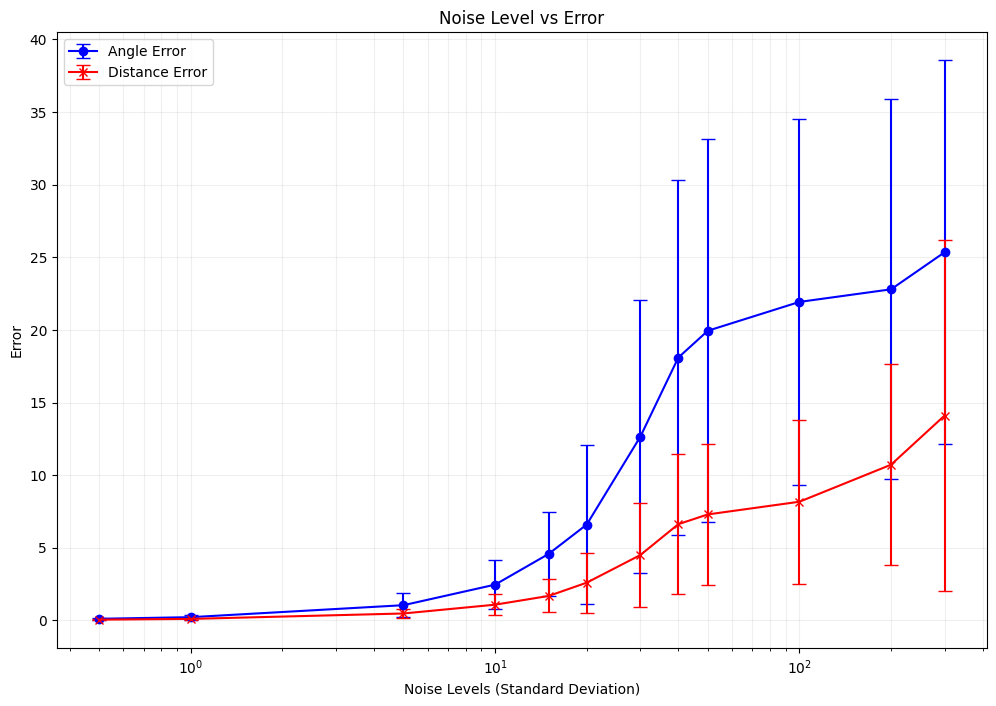

In [377]:
theta = 45
d = 20
noise_levels = [0.5, 1, 5, 10, 15, 20, 30, 40, 50,100,200,300]
errors = {}
runs_per_level = 100

# for each noise level, we run several times and take mean for fair value as the noise generation is random
for noise_level in noise_levels:
    level_theta_errors = []
    level_distance_errors = []
    for _ in range(runs_per_level):
        noisy_x, noisy_y = generate_noisy_points(theta, d, noise_level)
        theta_estimated, d_estimated = estimate_parameters(noisy_x, noisy_y)
        theta_error, d_error = compute_error(theta, d, theta_estimated, d_estimated)
        level_theta_errors.append(theta_error)
        level_distance_errors.append(d_error)
    errors[noise_level] = (np.mean(level_theta_errors), np.mean(level_distance_errors), 
                           np.std(level_theta_errors), np.std(level_distance_errors))

angle_errors = [errors[n][0] for n in noise_levels]
distance_errors = [errors[n][1] for n in noise_levels]
angle_std_devs = [errors[n][2] for n in noise_levels]
distance_std_devs = [errors[n][3] for n in noise_levels]

# we plot the std_dev of the errors as well to measure how inconsistent the values could be as we increase noise levels
plt.figure(figsize=(12, 8))
plt.errorbar(noise_levels, angle_errors, yerr=angle_std_devs, fmt='o-', label='Angle Error', color='blue', capsize=5)
plt.errorbar(noise_levels, distance_errors, yerr=distance_std_devs, fmt='x-', label='Distance Error', color='red', capsize=5)
plt.xscale('log')
plt.xlabel('Noise Levels (Standard Deviation)')
plt.ylabel('Error')
plt.title('Noise Level vs Error')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


5. Introduce a percentage of outliers to the point set and re-estimate the line parameters. Plot the error as a function of the percentage of outliers. Use the cv2.fitLine function to estimate the parameters, utilizing the CV_DIST_L2 distance.This "point set" means noisy point set. Add outliers to noise set so that it contains both noise and outlier points.Plot the error as a function of the percentage of outliers.



Outlier vs Noise--->Outlier is generated from a subset of points introducing drastic changes to them while noise is applied to every point with the same variation aroud the truth value

In [436]:
#Generate a percentage of outlier from total points and set a range to determine how far/worse can the outlier be 

def generate_outliers(noisy_x, noisy_y, percentage, outlier_range):
    total_points = len(noisy_x)
    num_outliers = int(total_points * percentage / 100)
    
    chosen_indices = np.random.choice(total_points, num_outliers, replace=False)
    
    for index in chosen_indices:
        noisy_x[index] += np.random.uniform(-outlier_range, outlier_range)
        noisy_y[index] += np.random.uniform(-outlier_range, outlier_range)
    
    return noisy_x, noisy_y



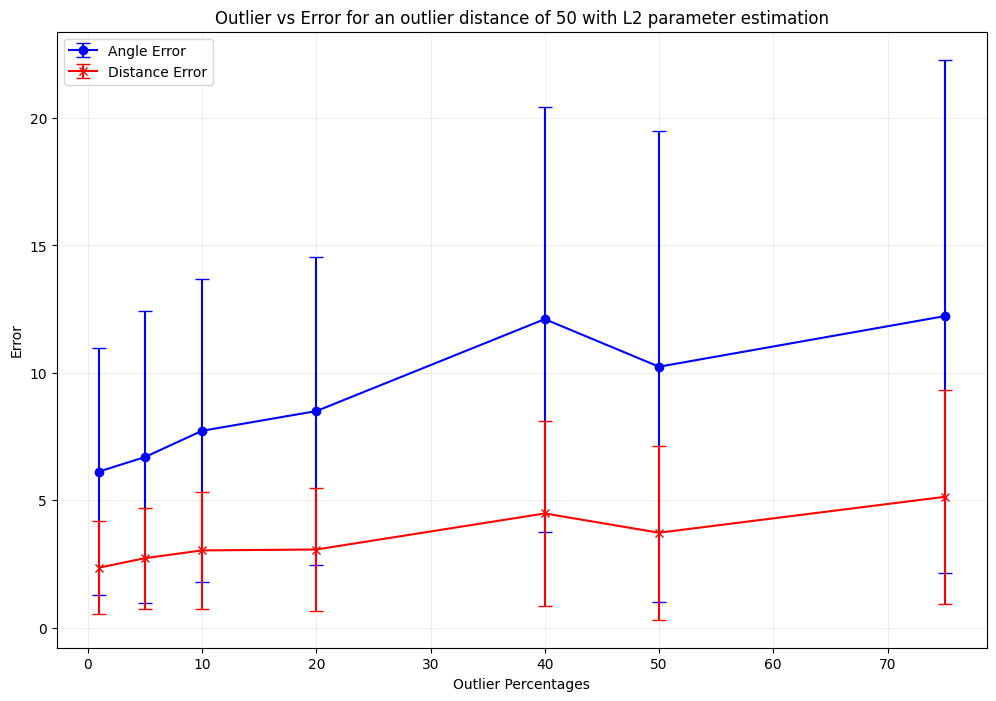

In [445]:
theta = 45
d = 20
std_dev= 20
outlier_percentages = [1,5,10,20,40,50,75]
outlier_range = 50
errors = {}
runs_per_level = 100

# for each outlier percentage, we run several times and take mean for fair value as the outlier generation is random
for percent in outlier_percentages:
    percent_theta_errors = []
    percent_distance_errors = []
    for _ in range(runs_per_level):
        noisy_x, noisy_y = generate_noisy_points(theta, d, std_dev)        
        noisy_outlier_x, noisy_outlier_y = generate_outliers(noisy_x,noisy_y,percent,outlier_range)
        theta_estimated, d_estimated = estimate_parameters(noisy_outlier_x, noisy_outlier_y)
        theta_error, d_error = compute_error(theta, d, theta_estimated, d_estimated)
        percent_theta_errors.append(theta_error)
        percent_distance_errors.append(d_error)
    errors[percent] = (np.mean(percent_theta_errors), np.mean(percent_distance_errors), 
                           np.std(percent_theta_errors), np.std(percent_distance_errors))

angle_errors = [errors[p][0] for p in outlier_percentages]
distance_errors = [errors[p][1] for p in outlier_percentages]
angle_std_devs = [errors[p][2] for p in outlier_percentages]
distance_std_devs = [errors[p][3] for p in outlier_percentages]

# we plot the std_dev of the errors as well to measure how inconsistent the values could be as we increase noise levels
plt.figure(figsize=(12, 8))
plt.errorbar(outlier_percentages, angle_errors, yerr=angle_std_devs, fmt='o-', label='Angle Error', color='blue', capsize=5)
plt.errorbar(outlier_percentages, distance_errors, yerr=distance_std_devs, fmt='x-', label='Distance Error', color='red', capsize=5)
plt.xlabel('Outlier Percentages')
plt.ylabel('Error')
plt.title('Outlier vs Error for an outlier distance of 50 with L2 parameter estimation')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


6. Use the cv2.fitLine function for robust line estimation, utilizing the CV_DIST_HUBER distance. Plot the error as a function of the percentage of outliers. 

In [438]:
def estimate_parameters_huber(noisy_x,noisy_y):

    noisy_points = np.column_stack((noisy_x,noisy_y)).astype(np.float32)
    direction_x,direction_y, x,y = cv2.fitLine(noisy_points,distType=cv2.DIST_HUBER,param=0,reps=0.01, aeps=0.01)  
    # distType=cv2.DIST_L2 - Euclidean (L2) distance -least squares method- sqrt((x1-x2)^2 + (y1-y2)^2)
    # param- setting threshold for other distypes,  reps - maximum radial (dist) accuracy threshold allowed, aeps- maximum angle accuracy threshold allowed
    # dir_x,dir_y,x,y - all are returned as single-element arrays ---we can use np.atan, np multiplications below as well

    theta_estimated = math.atan2(direction_y[0],direction_x[0])  # atan2 return angles in all 4 quadrants , The angle between the positive x-axis and the ray from the origin (0, 0) to the point (direction_x, direction_y)
    theta_estimated = math.degrees(theta_estimated) %360
    d_estimated = abs((direction_y[0] * x[0]) + (- direction_x[0] * y[0]))

    return theta_estimated, d_estimated

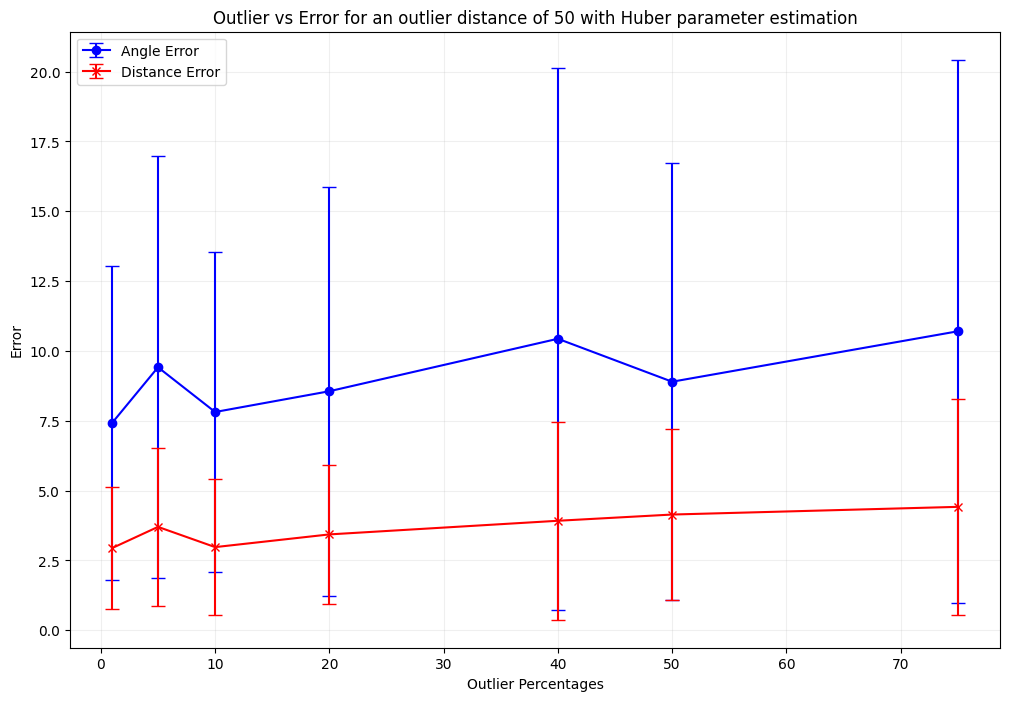

In [449]:
theta = 45
d = 20
std_dev= 20
outlier_percentages = [1,5,10,20,40,50,75]
outlier_range = 50
errors = {}
runs_per_level = 100

# for each outlier percentage, we run several times and take mean for fair value as the outlier generation is random
for percent in outlier_percentages:
    percent_theta_errors = []
    percent_distance_errors = []
    for _ in range(runs_per_level):
        noisy_x, noisy_y = generate_noisy_points(theta, d, std_dev)        
        noisy_outlier_x, noisy_outlier_y = generate_outliers(noisy_x,noisy_y,percent,outlier_range)
        theta_estimated, d_estimated = estimate_parameters_huber(noisy_outlier_x, noisy_outlier_y)
        theta_error, d_error = compute_error(theta, d, theta_estimated, d_estimated)
        percent_theta_errors.append(theta_error)
        percent_distance_errors.append(d_error)
    errors[percent] = (np.mean(percent_theta_errors), np.mean(percent_distance_errors), 
                           np.std(percent_theta_errors), np.std(percent_distance_errors))

angle_errors = [errors[p][0] for p in outlier_percentages]
distance_errors = [errors[p][1] for p in outlier_percentages]
angle_std_devs = [errors[p][2] for p in outlier_percentages]
distance_std_devs = [errors[p][3] for p in outlier_percentages]

# we plot the std_dev of the errors as well to measure how inconsistent the values could be as we increase noise levels
plt.figure(figsize=(12, 8))
plt.errorbar(outlier_percentages, angle_errors, yerr=angle_std_devs, fmt='o-', label='Angle Error', color='blue', capsize=5)
plt.errorbar(outlier_percentages, distance_errors, yerr=distance_std_devs, fmt='x-', label='Distance Error', color='red', capsize=5)
plt.xlabel('Outlier Percentages')
plt.ylabel('Error')
plt.title('Outlier vs Error for an outlier distance of 50 with Huber parameter estimation')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


7. Evaluate the algorithm and report results


Noise level vs Errors Graph:

1. We see that both the angle and distance error increases with the increase in the noise level. We also see from the bars in the graphs that they vary highly for higher noise levels because of too much randomness in the points.
2. The angle error is generally higher than the distance error at all noise levels
3. The angle error increases rapidly compared to the distance error at higher noise levels


Outliers vs Errors Graph:

1. We see that both the angle and distance error increases with the increase in the outliers. We also see from the bars in the graphs that they vary highly for higher percentage of outliers because many points are away from the line.
2. The angle error is generally higher than the distance error at all outliers
3. The angle error increases rapidly compared to the distance error at higher outliers

The main difference between Noise and Outlier graph is that error has high variance for outliers than noise levels. This shows that the performance is more sensitive to outliers than the noise level.


Outlier graph with HUBER parameter estimation has less variance and smaller errors compared to the outlier graph with L2 thereby HUBER offering more obust estimation.
